In [ ]:
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict
import re
from bs4 import BeautifulSoup
import sys
import os
os.environ['KERAS_BACKEND']='theano' # Why theano why not
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

In [ ]:
def clean_str(string):
    string = re.sub(r"\\", "", string)
    string = re.sub(r"\'", "", string)
    string = re.sub(r"\"", "", string)
    return string.strip().lower()

In [ ]:
MAX_SEQUENCE_LENGTH = 1000
MAX_NB_WORDS = 20000
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.2

In [ ]:
df = pd.read_csv('preprocess_data.txt',delimiter=',',engine='python',error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
Skipping line 4160: unexpected end of data


In [ ]:
# reading data

df = df.dropna()
df = df.reset_index(drop=True)
print('Shape of dataset ',df.shape)
print(df.columns)
df['class'] = df['Type']
print('No. of unique classes',len(set(df['class'])))

Shape of dataset  (4158, 5)
Index(['Unnamed: 0', 'Unnamed: 0.1', 'Name', 'Type', 'Text'], dtype='object')
No. of unique classes 16


In [ ]:
macronum=sorted(set(df['class']))
macro_to_id = dict((note, number) for number, note in enumerate(macronum))

def fun(i):
    return macro_to_id[i]

df['class']=df['class'].apply(fun)

In [ ]:
texts = []
labels = []
df['message'] = df['Type']
for idx in range(df.message.shape[0]):
    text = BeautifulSoup(df.message[idx])
    texts.append(clean_str(str(text.get_text().encode())))

for idx in df['class']:
    labels.append(idx)

In [ ]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Number of Unique Tokens',len(word_index))

Number of Unique Tokens 16


In [ ]:
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

labels = to_categorical(np.asarray(labels))
print('Shape of Data Tensor:', data.shape)
print('Shape of Label Tensor:', labels.shape)

indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
nb_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-nb_validation_samples]
y_train = labels[:-nb_validation_samples]
x_val = data[-nb_validation_samples:]
y_val = labels[-nb_validation_samples:]

Shape of Data Tensor: (4158, 1000)
Shape of Label Tensor: (4158, 16)


In [ ]:
embeddings_index = {}
f = open('glove.6B.100d.txt',encoding='utf8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Total %s word vectors in Glove 6B 100d.' % len(embeddings_index))

Total 1225 word vectors in Glove 6B 100d.


In [ ]:
embedding_matrix = np.random.random((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,trainable=True)

In [ ]:
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(len(macronum), activation='softmax')(l_dense)

model = Model(sequence_input, preds)
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

print("Simplified convolutional neural network")
model.summary()
cp=ModelCheckpoint('model_cnn.hdf5',monitor='val_acc',verbose=1,save_best_only=True)

Simplified convolutional neural network
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1000)]            0         
                                                                 
 embedding (Embedding)       (None, 1000, 100)         1700      
                                                                 
 conv1d (Conv1D)             (None, 996, 128)          64128     
                                                                 
 max_pooling1d (MaxPooling1D  (None, 199, 128)         0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 195, 128)          82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 39, 128)          0         
 1D)                 

In [ ]:
history=model.fit(x_train, y_train, validation_data=(x_val, y_val),epochs=15, batch_size=2,callbacks=[cp])

Epoch 1/15
1664/1664 [==============================] - ETA: 0s - loss: 2.2615 - acc: 0.2435
Epoch 1: val_acc improved from -inf to 0.23706, saving model to model_cnn.hdf5
1664/1664 [==============================] - 17s 5ms/step - loss: 2.2615 - acc: 0.2435 - val_loss: 2.1881 - val_acc: 0.2371
Epoch 2/15
1652/1664 [============================>.] - ETA: 0s - loss: 2.2114 - acc: 0.2455
Epoch 2: val_acc did not improve from 0.23706
1664/1664 [==============================] - 7s 4ms/step - loss: 2.2126 - acc: 0.2453 - val_loss: 2.1788 - val_acc: 0.2371
Epoch 3/15
1659/1664 [============================>.] - ETA: 0s - loss: 2.2077 - acc: 0.2456
Epoch 3: val_acc did not improve from 0.23706
1664/1664 [==============================] - 7s 4ms/step - loss: 2.2083 - acc: 0.2453 - val_loss: 2.1786 - val_acc: 0.2371
Epoch 4/15
1662/1664 [============================>.] - ETA: 0s - loss: 2.2090 - acc: 0.2449
Epoch 4: val_acc did not improve from 0.23706
1664/1664 [==============================

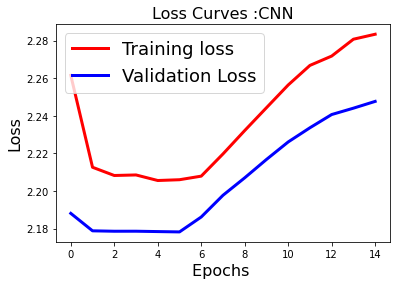

In [ ]:
fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

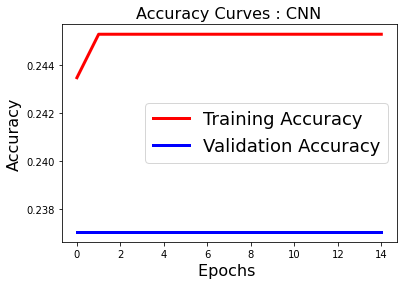

In [ ]:
fig2=plt.figure()
plt.plot(history.history['acc'],'r',linewidth=3.0)
plt.plot(history.history['val_acc'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves : CNN',fontsize=16)
fig2.savefig('accuracy_cnn.png')
plt.show()

In [ ]:
#from keras.utils.vis_utils import plot_model
#plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
from PIL import Image
display(Image.open('cnn_model.png'))

FileNotFoundError: ignored